# Рекуррентные языковые модели (4 балла)

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSj85jp-W-V-Bz8ZBjFJYIkV1TTxQxTMh4iqls_rRt8O-sraL08PA)

В этой части домашней работы мы создадим языковую модель на рекуррентных нейросетях (RNN) и заставим её придумывать имена.

__Языковая модель__, если вкратце, это модель, которая умеет как предсказывать вероятность некоторого текста, так и генерировать текст в соответствии с предсказанными вероятностями. Задание будет заключаться в том, чтобы суметь скормить модели 8к имён, после чего она могла бы генерировать новые.

В данном случае в качестве входных данных мы будет работать со строками, которые можно рассматривать как последовательности _символов_: $\{x_0, x_1, x_2, ..., x_n\}$. 

Наша основная задача — научиться предсказывать вероятность следующего символа:
$$ p(x_0, x_1, x_2, ..., x_n) = \prod_t p(x_t | x_0, ... x_{t - 1}) $$

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Данные

Мы будем строить языковую модель по ~8k человеческих имён на латинице. Если когда-нибудь вам нужно будет дать имя своему ребёнку, у вас будет для этого генеративная нейросетевая модель.

А теперь загрузите данные и постройте диаграмму распределения длины имен. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
start_token = " "

with open("/content/drive/My Drive/lab_4/names") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + name for name in lines]

In [0]:
print ('n samples = ',len(lines))
for x in lines[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


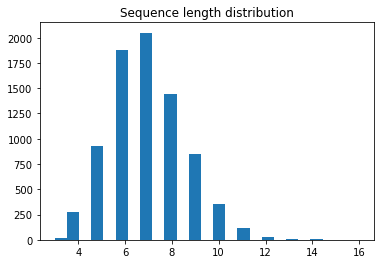

In [0]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)), bins=25);

## Словари

В начале нам будет необходимо построить "словарь" — упорядоченное множество уникальных символов, которые сеть может породить. Это нужно, чтобы уметь сопоставить каждому символу свой номер. Перед отправкой в сеть все символы будут кодироваться их номерами в словаре.

Также необходимо добавить в словарь пробельный символ, который будет использоваться в качестве специального токена.

In [0]:
# соберите все уникальные символы из lines
tokens = {l for line in lines for l in line}
tokens.add(' ')

tokens = sorted(list(tokens))

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60

n_tokens =  55


А теперь построим обратный словарь: для каждой буквы посчитаем её номер в списке токенов.

In [0]:
# словарь {символ -> его индекс в tokens}

token_to_id = {symbol: idx for idx, symbol in enumerate(tokens)}

In [0]:
assert len(tokens) == len(token_to_id), "число токенов должно совпадать"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "словарь должен указывать на индекс буквы в tokens"

print("Кажется заработало...")

Кажется заработало...


Имея построенное соответствие, можно преобразовать батч входных данных в матрицу int32 номеров токенов. Так как в батче все строки должны быть одной длины, слишком короткие строки в батче нужно будет дополнить пробелами (паддинг).

In [0]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i]))
        lines_ix[i, :len(line_ix)] = line_ix

    return lines_ix

In [0]:
# example: cast 4 random names to matrices, pad with zeros
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[ 0  3 30 29 35 29 33 40  0]
 [ 0  9 40 43 46 53  0  0  0]
 [ 0 18 46 37 47 47 37 33  0]
 [ 0  9 37 43 50 29 42 42 33]]


## Один RNN

Рекуррентная нейронная сеть (RNN) — это такая сеть с <s>блокнотом</s>состоянием $h$, в который она умеет писать то, что видела.

Сеть начинает с пустого $h_0 = \vec 0$, после чего текст обрабатывается по одному символу:
* $x_t$ — очередной символ, $h_t$ — предыдущее состояние
* $h_{t+1} = \text{get_h_next}(h_t, x_t)$ — новое состояние
* $p(x_{t+1} | h_{t+1}) = \text{get_probs}(h_{t+1})$ — вероятность следующего символа



<img src="https://i.imgur.com/8l4qFF0.png" width=480>

Поскольку $x_t$ это индекс символа в словаре (=натуральное число), то ему можно сопоставить некоторый обучаемый вектор (*embedding*).

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
print('TF version:', tf.__version__)


class CharRNN(keras.models.Model):
    
    def __init__(self, emb_size=16, hid_size=64):
        self.emb_size, self.hid_size = emb_size, hid_size
        super().__init__()
        
        # слой, который сопоставляет каждому из n_tokens входов свой обучаемый вектор
        self.emb = L.Embedding(n_tokens, emb_size)

        # слой, вычисляющий следующее состояния [emb(x_t), h_t] -> h_{t+1}
        self.rnn_update = L.Dense(hid_size, activation='tanh')

        # слой, предсказывающий вероятности h_{t+1} -> P(x_{t+1}|h_{t+1})
        self.rnn_to_probs = L.Dense(n_tokens, activation='softmax')
        
    def __call__(self, x_t, h_t):
        """
        Perform rnn step, return next rnn state and probabilities for next token
        :param h_t: previous rnn state, float32 [batch_size, rnn_size]
        :param x_t: token indices for current step, int32 [batch_size]
        """
        
        # Ваша задача: реализовать 1 шаг рекуррентной сети
        # замените номер символа на его вектор (embedding)
        # сконкатенируйте вектор входа и предыдущее состояние
        # вычислите следующее состояние сети
        # предскажите вероятности для языковой модели P(x_next | h_next)

        x_t_embedding = self.emb(x_t)
        x_and_h = np.concatenate([x_t_embedding, h_t], axis=1)
        h_next = self.rnn_update(x_and_h)
        output_probs = self.rnn_to_probs(h_next)
        
        return h_next, output_probs

TF version: 2.2.0


In [0]:
model = CharRNN()

# test: rnn one step
sequences = tf.convert_to_tensor(to_matrix(lines[:3]))
h0 = tf.zeros([len(sequences), model.hid_size])

h1, p_y1 = model(sequences[:, 0], h0)

assert h1.shape == (len(sequences), model.hid_size)
assert tf.reduce_all(tf.math.is_finite(h1))
assert np.allclose(tf.reduce_sum(p_y1, axis=1), tf.ones(len(sequences)))
assert tf.reduce_min(p_y1) >= 0

## Много шагов RNN

После того как был реализован один шаг нейросети, самое время сделать этих шагов побольше. Самый простой способ это сделать — написать цикл для фиксированного числа шагов.

In [0]:
# начальное состояние ("блокнот") из нулей
h_prev = tf.zeros([len(sequences), model.hid_size])
predicted_probs = []

for t in range(sequences.shape[1]):
    x_t = sequences[:, t]
        
    # Задача: вычислите следующее состояние rnn и пре
    # YOUR CODE: задайте h_next и probs_next
    
    h_next, probs_next = model(x_t, h_prev)
    
    # END OF YOUR CODE
    
    predicted_probs.append(probs_next)
    h_prev = h_next
    
predicted_probs = tf.stack(predicted_probs, axis=1)

print("Predicted probs (subset): \n", predicted_probs[:1, :2, :3])

assert predicted_probs.shape == (sequences.shape[0], sequences.shape[1], n_tokens)
assert h_prev.shape.as_list() == h0.shape.as_list()
assert np.allclose(tf.reduce_sum(predicted_probs, -1), tf.ones_like(predicted_probs[:, :, 0]))
assert not np.allclose(predicted_probs[:, 1, :] , predicted_probs[:, 2, :])

Predicted probs (subset): 
 tf.Tensor(
[[[0.01794644 0.01826064 0.018379  ]
  [0.01781716 0.01798576 0.01789339]]], shape=(1, 2, 3), dtype=float32)


## Обучение RNN

Как и любую вероятностную модель, RNN можно обучить методом максимизации log-правдоподобия по всей выборке $D$:

$$ \theta = \underset \theta {argmax} \log P(D) $$

где
$$ \log P(D) = \underset {\vec x \in D} \sum \log P(\vec x) = \underset {\vec x \in D} \sum \underset {x_t \in \vec x} \sum \log P(x_t | x_0, ..., x_{t+1})$$

C тем же успехом мы можем __минимизировать__ кроссэнтропию — то же самое, но минусом.

In [0]:
def compute_loss(sequences):
    """ Примените нейросеть на батче данных и вычислите функцию потерь """
    
    # 1. примените RNN в цикле по токенам в sequences
    # Для этого достаточно скопировать ваш код из предыдущего задания
    
    h_prev = tf.zeros([len(sequences), model.hid_size])
    predicted_probs = []

    for t in range(sequences.shape[1]):
        x_t = sequences[:, t]
        h_next, probs_next = model(x_t, h_prev)
        predicted_probs.append(probs_next)
        h_prev = h_next
        
    predicted_probs = tf.stack(predicted_probs, axis=1)
    
    # 2. вычислите функцию потерь - кроссэнтропию (минус средняя лог-вероятность правильного ответа)
    # Правильный ответ для i-го примера на t-той позиции == буква на {t+1}-ой позиции того же примера
    # hint: в самом конце тетрадки есть подсказка
    
    xent_probs, xent_targets = predicted_probs[:, :-1], sequences[:, 1:]
    targets = tf.one_hot(xent_targets, n_tokens)

    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(targets, xent_probs))

    return loss

In [0]:
assert compute_loss(sequences).shape == (), "loss must be scalar"
assert compute_loss(sequences) > 0, "loss must be non-negative"
assert compute_loss(sequences) <= 10, "loss must be a averaged over all tokens"

### Цикл обучения

Здесь не будет ничего сложного: 
1. выбираем батч;
2. делаем шаг обучения;
3. что-нибудь печатаем на некоторых итерациях.

In [0]:
from IPython.display import clear_output
from random import sample
optimizer = keras.optimizers.Adam()
model = CharRNN()

history = []

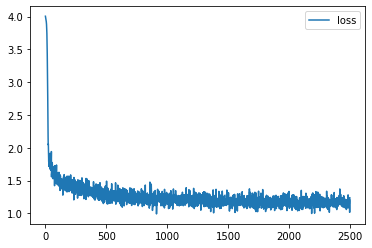

In [0]:
for i in range(2500):
    # sample a mini-batch of sequences and evaluate loss
    sequences = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
    
    with tf.GradientTape() as tape:
        loss_i = compute_loss(sequences)
    
    # compute gradients for all model.trainable_variables
    grads = tape.gradient(loss_i, model.trainable_variables)
    
    # update weights with optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    history.append(loss_i.numpy())
    if (i+1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

## Сэмплирование из RNN

Только что у нас обучилась модель, которая предсказывает вероятности следующего символа. Осталось заставить её генерировать имена.


Теперь давайте применим её к строке из одного пробела. Получим вероятности первой буквы имени. После чего сделаем в цикле:
* $x_t \sim P(x_t | h_t)$ — выберем букву пропорционально вероятностям.
* $h_{t+1}, p(x_{t+1}|...) = \text{model}(h_t, x_t)$ — присоединим букву к имени и прогоним через RNN

Таким нехитрым образом вы можете генерировать имена, выбирая по одной букве на каждой итерации цикла.

In [0]:
def generate_sample(seed_phrase=' ', max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    h = tf.zeros([1, model.hid_size])
    
    # feed the seed phrase, if any
    for x_t in x_sequence[:-1]:
        h, _ = model(tf.reshape(x_t, [1]), h)
    
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        h, x_probs = model(tf.reshape(x_sequence[-1], [1]), h)
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0].numpy()))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [0]:
for _ in range(10):
    print(generate_sample())

 Dia   r        
 GazP           
 Jvncr          
 Almaye         
 Saryil         
 Gsiita         
 Varay          
 Moreej         
 Chdde          
 Chng ta        


In [0]:
for _ in range(50):
    print(generate_sample(' Trump'))

 Trumpch yc     
 Trump          
 Trump          
 Trumpia        
 Trumpin        
 Trump          
 Trumpo         
 Trumprhn       
 Trump          
 Trump          
 Trump          
 Trump          
 Trump          
 Trump          
 Trump          
 Trump          
 Trump          
 Trumpe         
 Trumptoeler    
 Trumpa         
 Trump          
 Trump          
 Trumpita       
 Trump          
 Trump          
 Trump          
 Trumppr        
 Trump          
 Trumpe         
 Trump          
 Trumpe         
 Trumpsal       
 Trump          
 Trump          
 Trump          
 Trump          
 Trumpn         
 Trump          
 Trump          
 Trump          
 Trumpy         
 Trumps         
 Trump          
 Trumpee        
 Trump          
 Trumpn         
 Trumpd         
 Trumpn         
 Trump          
 Trump          


### Что теперь?

Если вам наскучит решать повседневные задачи или вам нужны новые идеи, вы теперь всегда можете воспользоваться RNN чтобы сгенерировать что-то новое. Вот несколько задач, от которых можно отталкиваться:
* названия статей по глубинному обучению;
* названия карт Magic The Gathering;
* [имена покемонов](https://github.com/cervoise/pentest-scripts/blob/master/password-cracking/wordlists/pokemon-list-en.txt);
* clickbait заголовки;
* молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system);
* ваша фантазия, с ограничениями которой вы уже должны были понять как бороться.

Если возьмётесь за эту задачу, то вот несколько полезных советов:
* Сейчас модель обучается на коротких строчках. Если у вас роман, его придётся порезать на кускочки.
* Если длина строк сильно варьируется, можно поставить параметр MAX_LENGTH так, чтобы он покрывал 90%. Это обычно дает ускорение примерно в 2 раза.
* Для более сложных задач требуется больше нейронов (rnn_size). Кроме того, можно эксперементировать и со составляющими сети (см. ниже).

### Ещё почитать

* [Подборка советов](https://danijar.com/tips-for-training-recurrent-neural-networks/) по обучению RNN. Чуть более полезная, чем обычно.
* Отличный блог-пост от Andrej Karpathy про языковые модели на rnn, их применение и визуализацию — [Unreasonable Effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
* Большой список статей, постов, реализаций и прочих полезностей по RNN - [awesome rnn](https://github.com/kjw0612/awesome-rnn).
* [Зоопарк](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) готовых рекуррентных ячеек (LSTM, GRU) в TF. И ещё одна реализация [в карасе](https://keras.io/layers/recurrent/).
* Сейчас мы выбираем количество итераций динамически. Если вы хотите написать то же самое на tf 1.0, милости просим в [tf.while_loop](https://www.tensorflow.org/api_docs/python/tf/while_loop) или [tf.scan](https://www.tensorflow.org/api_docs/python/tf/scan).
* А ещё рекуррентные сети можно аугментировать механизмом внимания или долговременной памятью. Вот тут есть [хорошая статья](https://distill.pub/2016/augmented-rnns/).

**Spoilers!** подсказка для вычисления функции потерь

Проще всего вычислить функцию потерь с использованием slices, например

```xent_probs, xent_targets = predicted_probs[:, :-1], sequences[:, 1:]```

Таким образом, в i-той строчке на j-том столбце в `xent_probs` содержатся предсказания, а в `targets` - соответствующие им же правильные "следующие буквы". Чтобы вычислить функцию потерь с этими переменными, можно воспользоваться `tf.one_hot` чтобы привести `targets` к размеру `xent_probs`.